# Variational AutoEncoder (VAE)
Train a VAE on the MNIST handwritten digit dataset. 

This makes use of: the custom Keras model class defined in vaegan.vae.py, our
class for loading the MNIST dataset defined in vaegan.data, and our custom Keras
callback in vaegan.callbacks.

A directory called 'output' will be created to save figures and the trained
model.


In [1]:
# nEpochs=20  # orig, longer, more reasonable amount of training
nEpochs = 3  # quick testing during development
%set_env CUDA_VISIBLE_DEVICES=1
%cd 04_ExerciseCodeAndInstructions/vaegan


env: CUDA_VISIBLE_DEVICES=1
/project/nanocourse/SWE_OOP/train07/Module_2_VMullapudi/04_ExerciseCodeAndInstructions/vaegan


## 1. Import 3rd party libraries

In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

print(tf.__version__)
print(tf.config.list_physical_devices("GPU"))


2025-05-27 14:29:43.280716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748374183.306150   32359 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748374183.313157   32359 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748374183.334632   32359 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748374183.334650   32359 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748374183.334652   32359 computation_placer.cc:177] computation placer alr

2.19.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Import our own classes (that we will complete together)

In [3]:
# Import our own classes
from vaegan.data import MNIST
from vaegan.callbacks import SaveImages
import vaegan.vae


## 3. Show some our data

I0000 00:00:1748374188.171134   32359 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15506 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:82:00.0, compute capability: 6.0


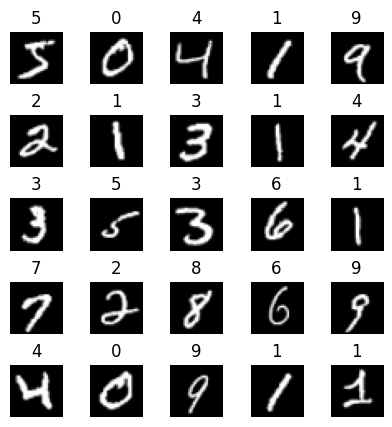

In [4]:
# Create output directory if it doesn't exist yet.
output_dir = "./outputs/mnist_vae"
os.makedirs(output_dir, exist_ok=True)

# Instantiate the MNIST class containing our training data.
data = MNIST()

# Show some example images and their labels.
data.show_example_images(os.path.join(output_dir, "example_images.png"))


## 4. Construct the model using the python class you completed

In [5]:
pyModule = reload(vaegan.vae)

# Create the model. Note that we're using mostly the default arguments, but this is
# where you might want to play around with different loss weights.
tf.random.set_seed(1234)
model = pyModule.VAE()

# This step tells Keras to compute the explicit output shapes of each layer.
# Otherwise, the layers will have dynamic/variable output shapes which is not
# compatible with saving and loading.

# TODO why isn't this working?
model.compute_output_shape((None, 32, 32, 1))
model.decoder.compute_output_shape((None, 8))


Loaded version: vaegan.vae


(None, 8)

## <span style="color:blue"> Correct model dimensions </span>
    

<span style="color:blue"> === OVERALL MODEL ==== </span>

```
Layer (type)                 Output Shape              Param #   
=================================================================
encoder (Encoder)            multiple                  240896    
_________________________________________________________________
decoder (Decoder)            multiple                  182145    
_________________________________________________________________
recon_loss (Mean)            multiple                  2         
_________________________________________________________________
kl_loss (Mean)               multiple                  2         
_________________________________________________________________
total_loss (Mean)            multiple                  2         
=================================================================
Total params: 423,047
Trainable params: 422,337
Non-trainable params: 710

```
<span style="color:blue"> === ENCODER SUBMODEL ====</span>
```
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_4 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 32, 32, 16)   272         input_4[0][0]                    
__________________________________________________________________________________________________
bn0 (BatchNormalization)        (None, 32, 32, 16)   64          conv0[1][0]                      
__________________________________________________________________________________________________
relu0 (ReLU)                    (None, 32, 32, 16)   0           bn0[1][0]                        
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 32)   8224        relu0[1][0]                      
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 16, 16, 32)   128         conv1[1][0]                      
__________________________________________________________________________________________________
relu1 (ReLU)                    (None, 16, 16, 32)   0           bn1[1][0]                        
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 8, 8, 64)     32832       relu1[1][0]                      
__________________________________________________________________________________________________
bn2 (BatchNormalization)        (None, 8, 8, 64)     256         conv2[1][0]                      
__________________________________________________________________________________________________
relu2 (ReLU)                    (None, 8, 8, 64)     0           bn2[1][0]                        
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 4, 4, 64)     65600       relu2[1][0]                      
__________________________________________________________________________________________________
bn3 (BatchNormalization)        (None, 4, 4, 64)     256         conv3[1][0]                      
__________________________________________________________________________________________________
relu3 (ReLU)                    (None, 4, 4, 64)     0           bn3[1][0]                        
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1024)         0           relu3[1][0]                      
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          131200      flatten[1][0]                    
__________________________________________________________________________________________________
dense_mean (Dense)              (None, 8)            1032        dense[1][0]                      
__________________________________________________________________________________________________
dense_logvar (Dense)            (None, 8)            1032        dense[1][0]                      
==================================================================================================
Total params: 240,896
Trainable params: 240,544
Non-trainable params: 352

```
<span style="color:blue"> === DECODER SUBMODEL ====</span>
```
Layer (type)                 Output Shape              Param #   
=================================================================
input_5 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              9216      
_________________________________________________________________
relu_dense (ReLU)            (None, 1024)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 64)          0         
_________________________________________________________________
tconv0 (Conv2DTranspose)     (None, 8, 8, 64)          65600     
_________________________________________________________________
bn0 (BatchNormalization)     (None, 8, 8, 64)          256       
_________________________________________________________________
relu0 (ReLU)                 (None, 8, 8, 64)          0         
_________________________________________________________________
tconv1 (Conv2DTranspose)     (None, 16, 16, 64)        65600     
_________________________________________________________________
bn1 (BatchNormalization)     (None, 16, 16, 64)        256       
_________________________________________________________________
relu1 (ReLU)                 (None, 16, 16, 64)        0         
_________________________________________________________________
tconv2 (Conv2DTranspose)     (None, 32, 32, 32)        32800     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 32, 32, 32)        128       
_________________________________________________________________
relu2 (ReLU)                 (None, 32, 32, 32)        0         
_________________________________________________________________
tconv3 (Conv2DTranspose)     (None, 32, 32, 16)        8208      
_________________________________________________________________
bn3 (BatchNormalization)     (None, 32, 32, 16)        64        
_________________________________________________________________
relu3 (ReLU)                 (None, 32, 32, 16)        0         
_________________________________________________________________
conv_out (Conv2D)            (None, 32, 32, 1)         17        
_________________________________________________________________
sigmoid_out (Activation)     (None, 32, 32, 1)         0         
=================================================================
Total params: 182,145
Trainable params: 181,793
Non-trainable params: 352

```
## 5. Now check your model's  dimensions against this list above

In [6]:
print("=== OVERALL MODEL ====")
model.summary()
print("=== ENCODER SUBMODEL ====")
enc_in = tf.keras.layers.Input(model.image_shape)
enc_out = model.encoder.call(enc_in)
enc = tf.keras.Model(enc_in, enc_out)
enc.summary()
print("=== DECODER SUBMODEL ====")
dec_in = tf.keras.layers.Input((model.n_latent_dims,))
dec_out = model.decoder.call(dec_in)
dec = tf.keras.Model(dec_in, dec_out)
dec.summary()


=== OVERALL MODEL ====


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

=== ENCODER SUBMODEL ====


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 32, 32,    │        272 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 32, 32,    │         64 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (ReLU)        │ (None, 32, 32,    │          0 │ bn0[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 16, 16,    │      8,224 │ relu0[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 16, 16,    │        128 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1 (ReLU)        │ (None, 16, 16,    │          0 │ bn1[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, 8, 8, 64)  │     32,832 │ relu1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2                 │ (None, 8, 8, 64)  │        256 │ conv2[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu2 (ReLU)        │ (None, 8, 8, 64)  │          0 │ bn2[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3 (Conv2D)      │ (None, 4, 4, 64)  │     65,600 │ relu2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn3                 │ (None, 4, 4, 64)  │        256 │ conv3[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu3 (ReLU)        │ (None, 4, 4, 64)  │          0 │ bn3[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1024)      │          0 │ relu3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    131,200 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_mean (Dense)  │ (None, 8)         │      1,032 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_logvar        │ (None, 8)         │      1,032 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 240,896 (941.00 KB)

 Trainable params: 240,544 (939.62 KB)

 Non-trainable params: 352 (1.38 KB)

=== DECODER SUBMODEL ====


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_dense (ReLU)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tconv0 (Conv2DTranspose)        │ (None, 8, 8, 64)       │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 8, 8, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu0 (ReLU)                    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tconv1 (Conv2DTranspose)        │ (None, 16, 16, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 16, 16, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (ReLU)                    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tconv2 (Conv2DTranspose)        │ (None, 32, 32, 32)     │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 32, 32, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (ReLU)                    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tconv3 (Conv2DTranspose)        │ (None, 32, 32, 16)     │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 32, 32, 16)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (ReLU)                    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_out (Conv2D)               │ (None, 32, 32, 1)      │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sigmoid_out (Activation)        │ (None, 32, 32, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182,145 (711.50 KB)

 Trainable params: 181,793 (710.13 KB)

 Non-trainable params: 352 (1.38 KB)

## 6. Compile the model 

In [7]:
# Compile the model with an optimizer. The learning rate of the optimizer can be
# specified here. Normally, this is also where you would select a loss function
# and any metrics. However, our custom model defines the loss functions inside
# its __init__ constructor, so we don't need to do that here.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Instantiate our custom callback to save a few example reconstructions and
# generated images after each epoch.
save_images_callback = SaveImages(
    output_dir=output_dir,
    model=model,
    example_images=data.images_train[:10],
    n_generated_images=10,
    n_latent_dims=model.n_latent_dims,
)


## 7. Train (fit) the model on the data 

In [8]:
# Train the model. Just like any off-the-shelf Keras model, we just call fit.
# Under the hood, Keras will call the train_step method of our custom subclass
# on each mini-batch and automatically loop through the training data. It will
# take care of all the details, like converting numpy arrays to tensors, showing
# a progress bar, and tracking the loss over the epochs.
logs = model.fit(
    data.images_train, batch_size=128, epochs=nEpochs, callbacks=[save_images_callback]
)


Epoch 1/3


I0000 00:00:1748374198.046215   32635 service.cc:152] XLA service 0x2aae8c007000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748374198.046254   32635 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2025-05-27 14:29:58.277009: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748374199.295395   32635 cuda_dnn.cc:529] Loaded cuDNN version 90300


  8/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - kl_loss: 11.3936 - recon_loss: 158.7341 - total_loss: 170.1277  

I0000 00:00:1748374204.352812   32635 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - kl_loss: 8.2835 - recon_loss: 54.0593 - total_loss: 62.3428
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - kl_loss: 10.9495 - recon_loss: 23.3429 - total_loss: 34.2924
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - kl_loss: 11.3435 - recon_loss: 20.9459 - total_loss: 32.2893


## 8. Training saves results to disk, now also plot training curves

/project/nanocourse/SWE_OOP/shared/CondaEnvs/lib/python3.12/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


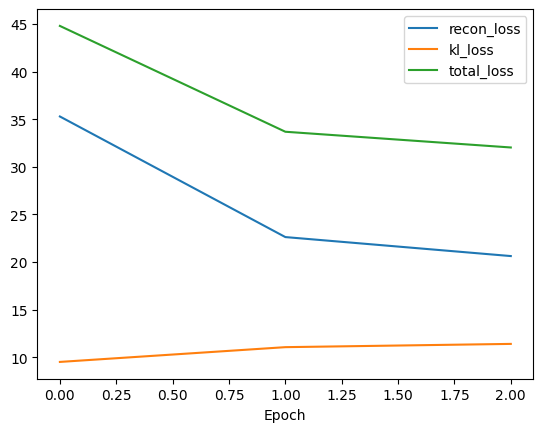

In [10]:
# Plot the training curves, which are stored in logs.history as a dict. Keys of
# this dict are the metric names, while the corresponding values are arrays.
fig, ax = plt.subplots()

for loss_name in ["recon_loss", "kl_loss", "total_loss"]:
    loss_values = logs.history[loss_name]
    x = np.arange(len(loss_values))
    ax.plot(x, loss_values, label=loss_name)

ax.legend()
ax.set_xlabel("Epoch")
fig.savefig(os.path.join(output_dir, "training_curves.png"), transparent=False)
# fig.show()

# Save the model
model.save(os.path.join(output_dir, "vae.keras"))
